# Simpsons DCGAN
### Emily Lupini

The following Simpsons Deep Convolutional Generative Adversarial Network (DCGAN) is inteded to generate images of Homer Simpson based off of preexisting Homer images. With this project I hope to demonstrate how Machine Learning, and specifically Generative Adversarial Networks, can create effective imposters that we may not expect.

I chose to use a DCGAN over other versions because convolutional neural networks have shown effectivenes with image recognition. 

For the discriminator I found adding an additional convolutional layer helped speed up the process for better image generation. Additionally, starting with a larger layer for the generator aided the efficiency. Using BatchNormalization and Dropouts ensured diverse data usage on my dataset.

---

# Imports
---

Libraries used:
* ` __future__`
    * ensures compatability with other versions of python
* `cv2`
    * file reading
* `numpy`
    * random integer selection
    * data generation
    * array formatting
* `pathlib` 
    * file reading
* `matplotlib.pylot`
    * image plotting
* `keras`
    * Sequential Neural Net

In [3]:
from __future__ import print_function, division

import cv2 as cv
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


# `class DCGAN()`

Ideas and Examples from Chapter 6 in _Keras Deep Learning Cookbook_ by Rajdeep Dua and Manpreet Sigh Ghotra.

* __Bolded methods are exclusively mine.__
* *Italacized methods are from the _Keras Deep Learning Cookbook_.*
* ***Both are a combination of my work and the examples found in the _Keras Deep Learning Cookbook_.***

---

* ***`__init__(self)`***
    * Parameters:
        * self
    * Returns:
        * none
    * Process:
        * __Process the data__
        * Define data shape
        * Build and compile the discriminator
        * Build the generator
        * Define input length for generator
        * Enforce that the discriminator does not train
        * Validate generated images
        * Create a combined model that compares generator with discriminator
        
* __`process_data(self)`__
    * Parameters:
        * self
    * Returns:
        * pkm
            * list of pokemon images
    * Process:
        * Read in images
        * Enforce white backgrounds

* __`plot_pkm(self)`__
    * Parameters:
        * self
    * Returns: 
        * none
    * Process:
        * Create 5X5 grid
        * Set grid size
        * Fill with first 25 images
        
* *`build_generator(self)`*
    * Parameters:
        * self
    * Returns:
        * Model(noise, img)
            * Model and data to be classified by the discriminator
    * Process:
        * 5 Layers:
            * Dense layer: 128 * 15 * 15    
                * Activation - `relu`
            * Convolutional 2D: 30, 30, 128 
                * Activation - `relu`
            * Convolutional 2D: 60, 60, 64  
                * Activation - `relu`
            * Convolutional 2D: 120, 120, 3 
                * Activation - `tanh`
* *`build_discriminator(self)`*
    * Parameters:
        * self
    * Returns:
        * Model(img, validity)
    * Process:
        * 6 Layers:
            * Convolutional 2D:  96, 96, 32  
                * Activation - `LeakyReLU`
            * Convolutional 2D:  48, 48, 64  
                * Activation - `LeakyReLU`
            * Convolutional 2d: 25, 25, 128
                * Activation - `LeakyReLU`
            * Convolutional 2D:  13, 13, 128 
                * Activation - `LeakyReLU`
            * Convolutional 2D:  7, 7, 256   
                * Activation - `LeakyReLU`
            * Dense Layer: 1                 
                * Activation - `sigmoid`

* *`train(self, epochs, batch_size=25, save_interval=50)`*
    * Parameters:
        * self
        * epochs
        * batch_size
            * How many images to generate/will be trained on
        * save_interval
            * At which epoch images will be saved/plotted
    * Returns: 
        * None
    * Process:
        * Create labels
        * At each epoch:
            * Select random images
            * Train the generator
            * Train the discriminator
            * Output 
            * Output/save images


* **`plot_images(self, epoch, gen_imgs)`**
    * Parameters:
        * self
        * epoch
            * Current epoch for title of save file
        * gen_imgs
            * Generated images to be plotted
    * Returns:
        * None
    * Process:
        * Create grid
        * Set grid size
        * Fill with gen_imgs

In [4]:
class DCGAN():
    
    def __init__(self):
        
        self.simpsons = self.process_data()
        self.plot_simpsons()
        self.simpsons = (np.asarray(self.simpsons) / 127.5) - 1
        
        self.img_rows = 192
        self.img_cols = 192
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        optimizer = Adam(0.0002, 0.5)
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                  optimizer=optimizer,
                                  metrics=['accuracy'])
        
        # Build the generator
        self.generator = self.build_generator()
        
        # The generator takes noise as input and generates images
        z = Input(shape=(100,))
        img = self.generator(z)
        
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
            
        # The discriminator takes generated images as input and 
        # determines validity
        valid = self.discriminator(img)
        
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', 
                              optimizer=optimizer)
        
    def process_data(self):
        simpsons = []

        img_path = 'simpsons-faces/homer'

        for simpson in Path(img_path).glob('*.png'):
            image = cv.imread(str(simpson), cv.IMREAD_UNCHANGED)
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            image = cv.resize(image, (192, 192))
            simpsons.append(image)
            
        return simpsons
    
    def plot_simpsons(self):
        rows = 4
        cols = 4
        axes = []
        fig = plt.figure()
        fig.set_size_inches(20, 15)
        for i in range(rows*cols):
            axes.append(fig.add_subplot(rows, cols, i+1))
            plt.imshow(self.simpsons[i])
            plt.axis('off')
        plt.show()
        
    def build_generator(self):
        model = Sequential()
        
        model.add(Dense(256 * 12 * 12, activation='relu',
                 input_dim=self.latent_dim))
        model.add(Reshape((12, 12, 256)))
        model.add(UpSampling2D())
        
        model.add(Conv2D(256, kernel_size=5, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        
        model.add(Conv2D(128, kernel_size=5, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        
        model.add(Conv2D(64, kernel_size=5, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        
        model.add(Conv2D(self.channels, 
                         kernel_size=5, 
                         padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2,
                        input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64, kernel_size=3, strides=2, 
                         padding="same"))
        model.add(ZeroPadding2D(padding=((0,1), (0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, 
                         padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, 
                         padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=2, 
                         padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        
        return Model(img, validity)
        
    def train(self, epochs, batch_size=25, save_interval=50):
        
        valid = np.zeros((batch_size, 1))
        fake = np.ones((batch_size, 1))
        
        for epoch in range(epochs):
            
            # Select a random half of images
            idx = np.random.randint(0, self.simpsons.shape[0],
                                   batch_size)
            imgs = self.simpsons[idx]
            
            # _____________________
            #   Train Generator
            # _____________________
            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size,
                                           self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            # Train the discriminator (real classified as ones
            # and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs,
                                                           valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs,
                                                           fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # _____________________
            #  Train Discriminator
            # _____________________
            
            # Train the generator (wants discriminator to mistake
            # images as real)
            g_loss = self.combined.train_on_batch(noise, valid)
            
            # If at save interval => save generated image
            # samples
            if epoch % save_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]"
                        % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.plot_images(epoch, gen_imgs)
                
    def plot_images(self, epoch, gen_imgs):
            rows = 1
            cols = 2
            axes = []
            fig = plt.figure()
            fig.set_size_inches(20, 15)
            for i in range(rows*cols):
                axes.append(fig.add_subplot(rows, cols, i+1))
                plt.imshow(gen_imgs[i] * 0.5 + 0.5)
                plt.axis('off')
            
            # Uncomment below for Jupyter Notebook use
            plt.show()
            
            # Creates file of images
            # Uncomment below for .py use
            # plt.savefig('homer_gen/lupini_%i_epoch.png' % (epoch))


# The Data
---

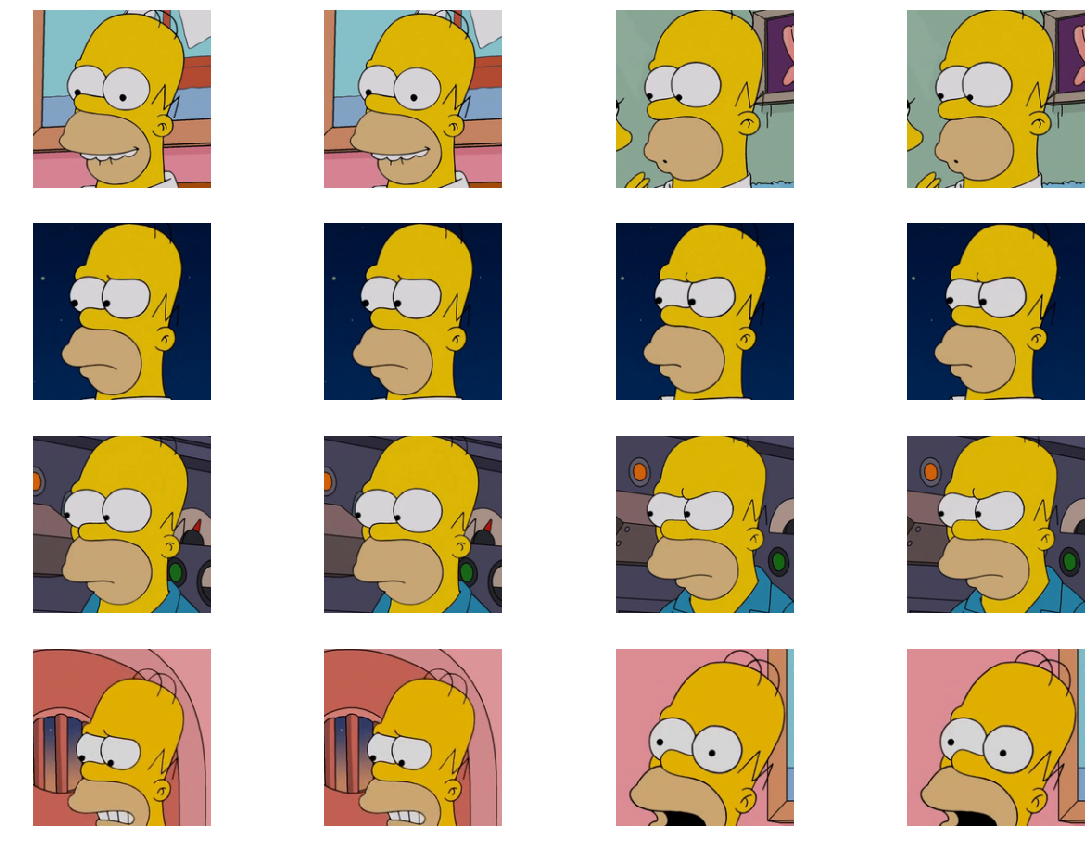

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 49, 49, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 49, 49, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 49, 49, 64)        0         
__________

In [5]:
dcgan = DCGAN()

# The Generated Data
---

C:\Users\Peter\AppData\Roaming\Python\Python36\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.536010, acc.: 75.00%] [G loss: 1.299664]


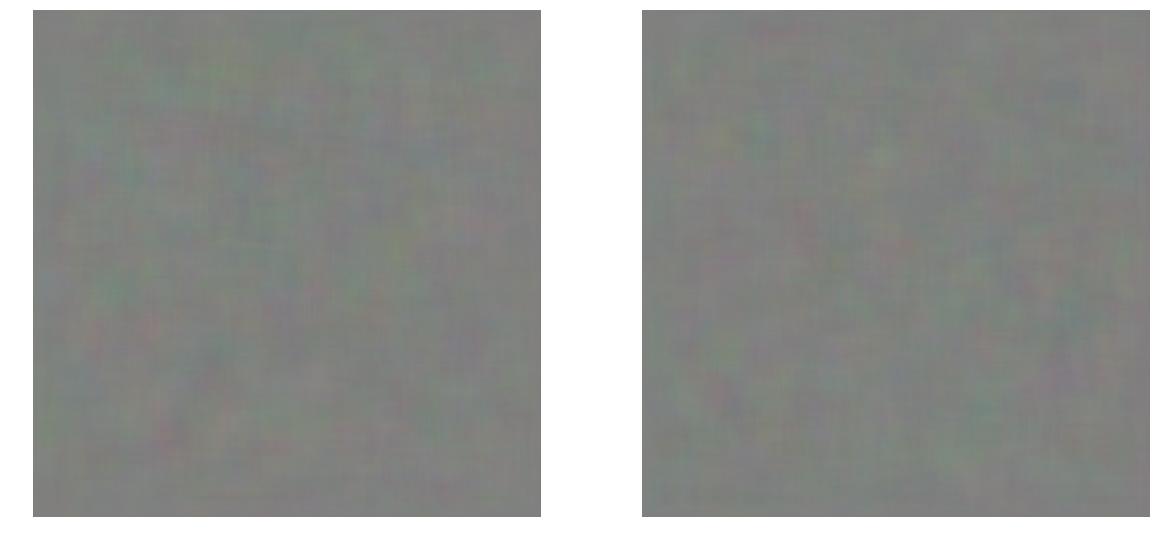

5000 [D loss: 0.289204, acc.: 75.00%] [G loss: 5.126907]


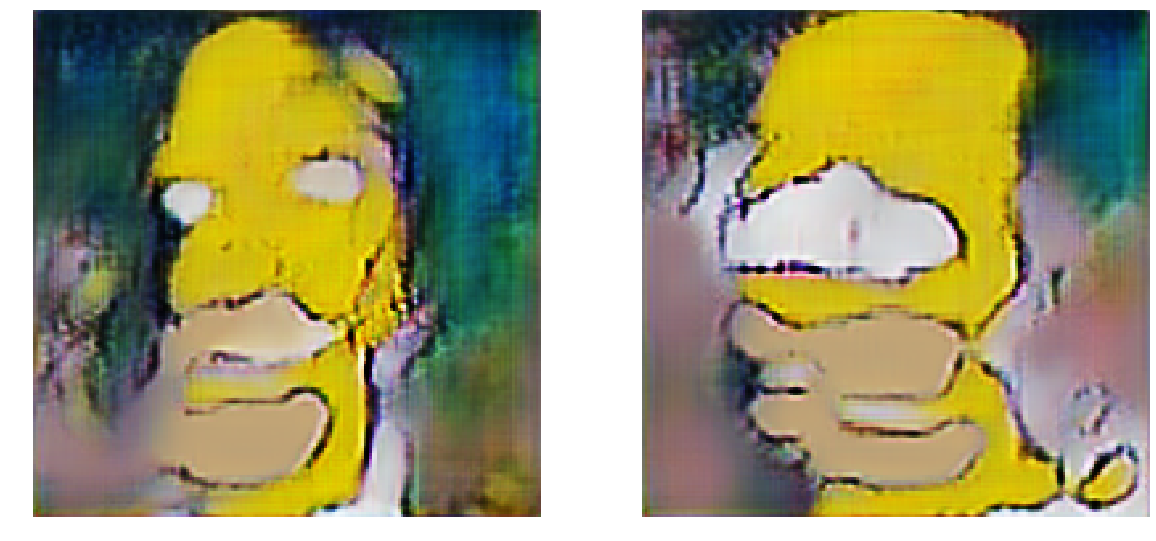

10000 [D loss: 0.061770, acc.: 100.00%] [G loss: 3.465416]


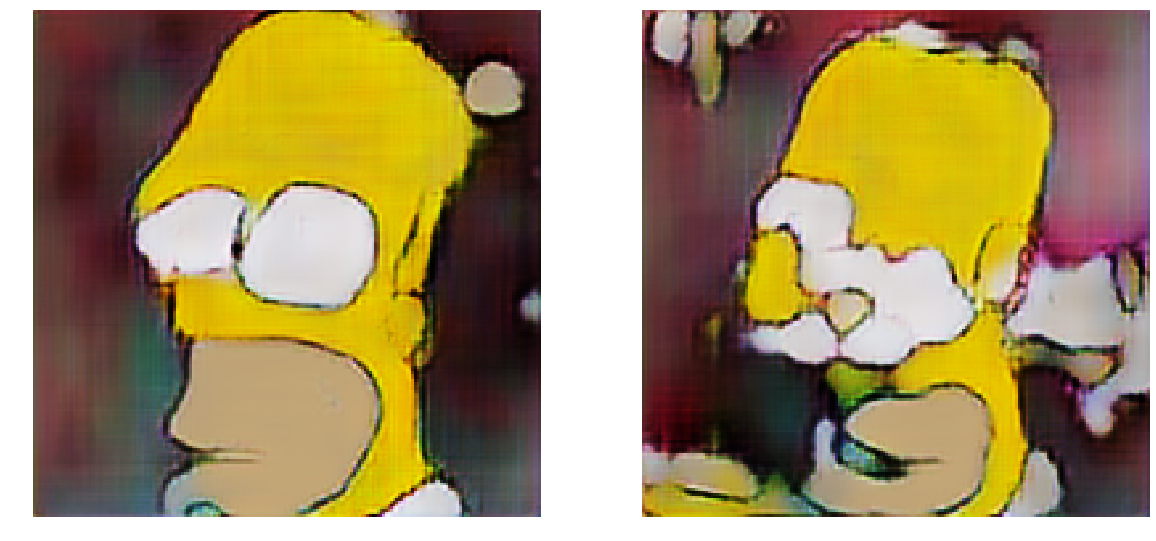

15000 [D loss: 1.810957, acc.: 50.00%] [G loss: 11.884327]


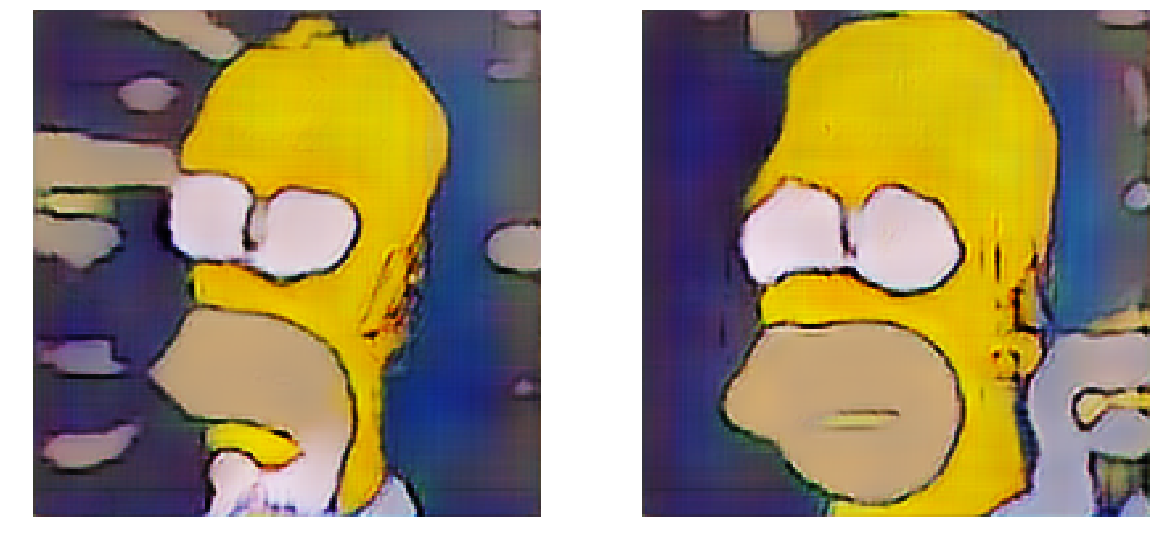

20000 [D loss: 0.007452, acc.: 100.00%] [G loss: 7.170214]


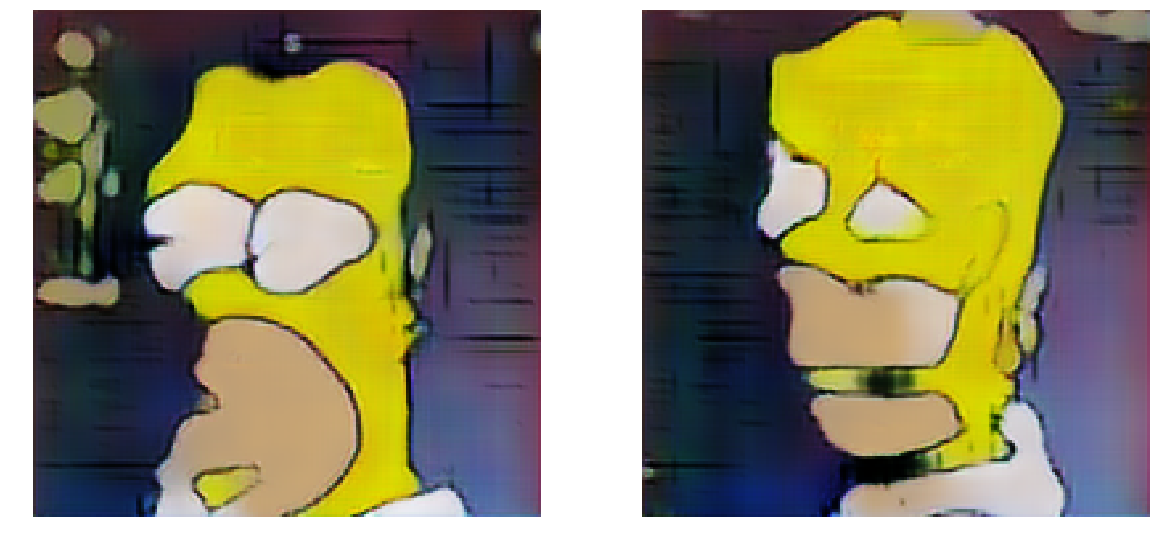

25000 [D loss: 0.313936, acc.: 75.00%] [G loss: 7.655161]


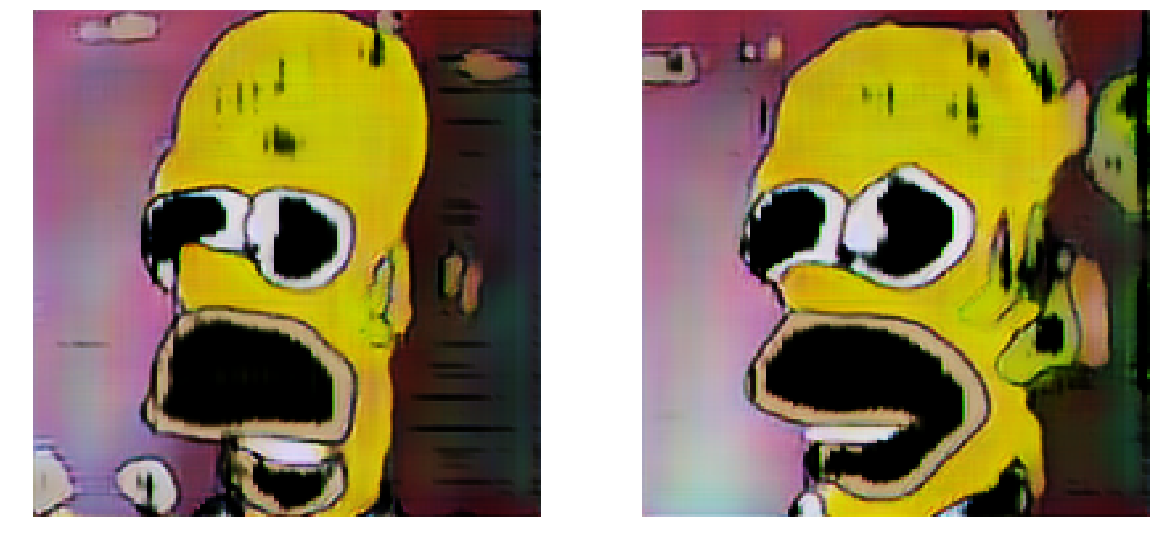

30000 [D loss: 0.001077, acc.: 100.00%] [G loss: 6.431171]


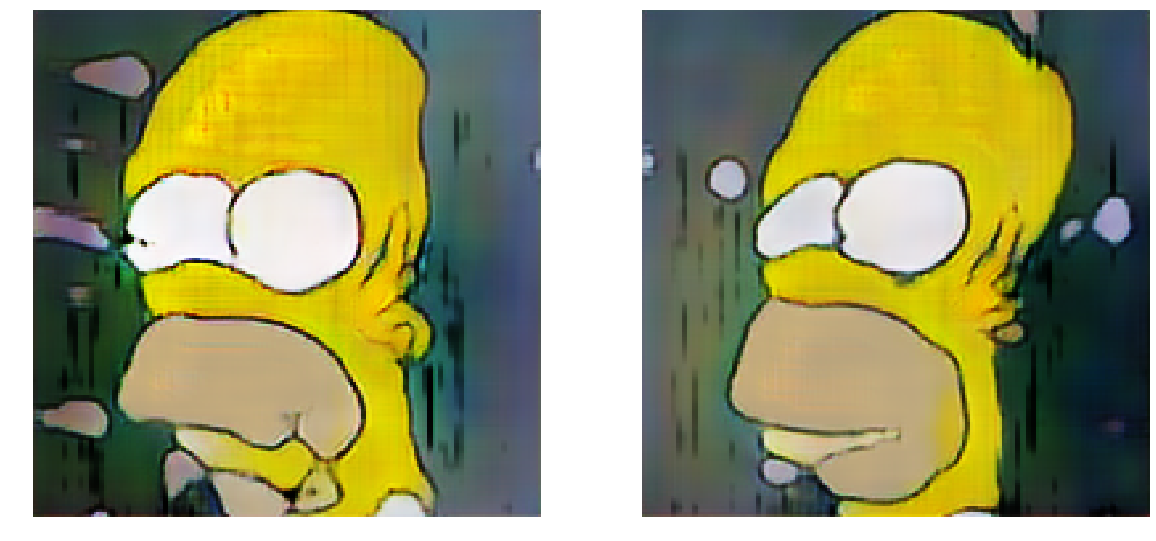

35000 [D loss: 0.046245, acc.: 100.00%] [G loss: 10.845091]


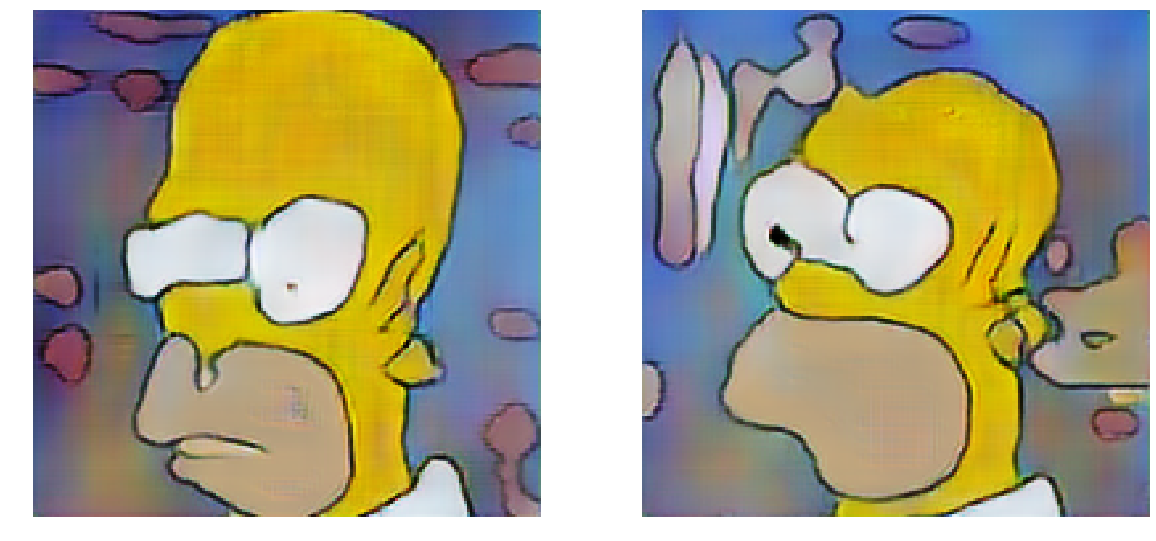

40000 [D loss: 0.012396, acc.: 100.00%] [G loss: 8.328177]


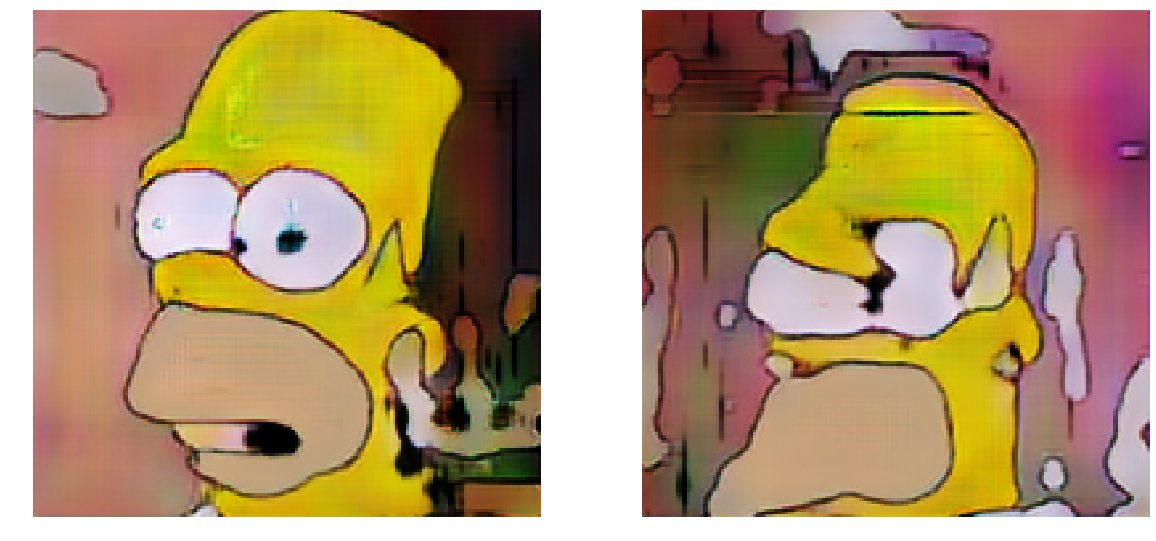

45000 [D loss: 0.000262, acc.: 100.00%] [G loss: 10.035692]


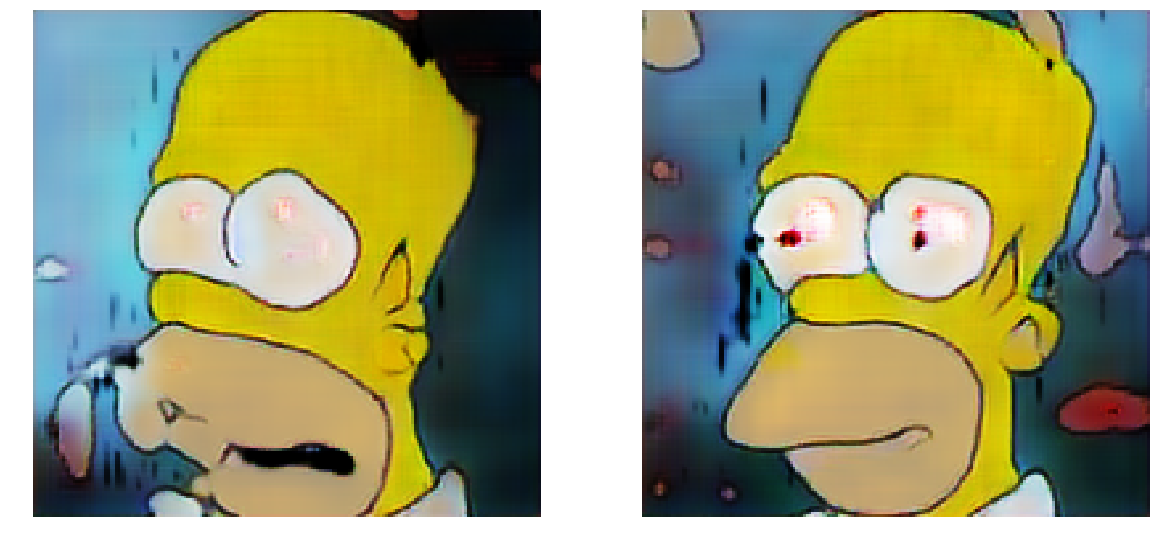

In [6]:
dcgan.train(epochs=50000, batch_size=2, save_interval=5000)